# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

## Import necessary libraries

In [2]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter
# import seaborn as sb

## Load input data and apply grayscale

We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Now each pixel will be 8 bits ranging from 0 (light) to 255 (dark).

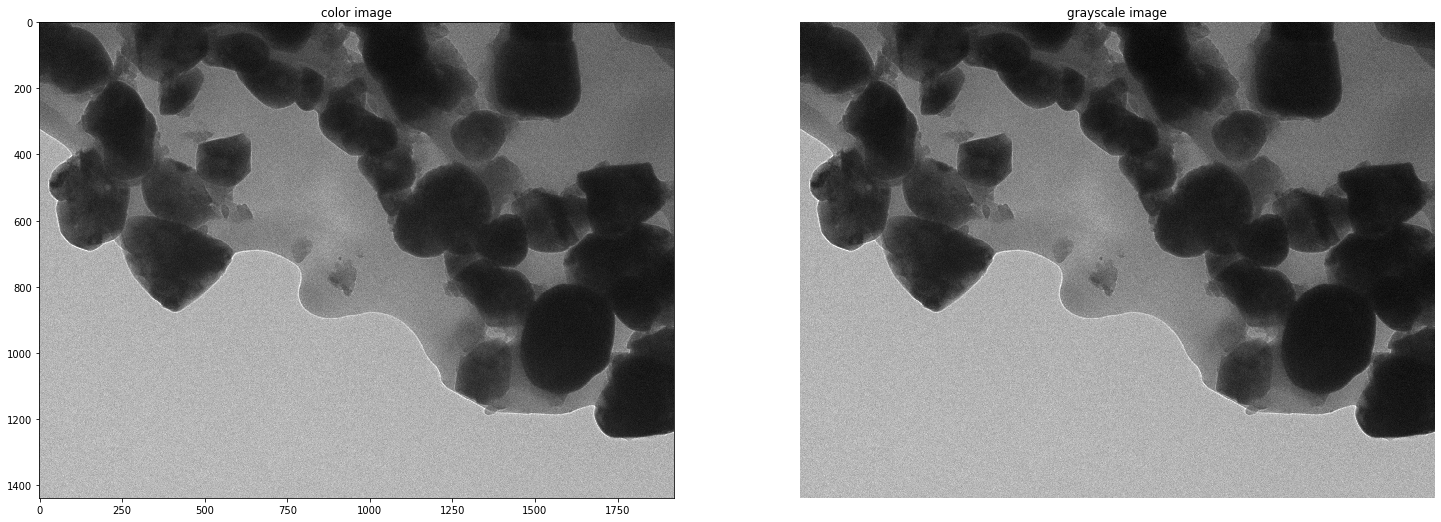

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-II-36a-cropped.tif"
# IMAGE_NAME = "500_scale_BM_20V_200_10=200_20_BM_100 no 10.png"
# IMAGE_NAME = "easy_particles.png" 

# color_image = cv.imread(IMAGE_NAME) # read a color image

# color_image = cv.cvtColor(color_image, cv.COLOR_BGR2RGB)                # convert from BGR to RGB
# not_color_image = cv.cvtColor(color_image, cv.COLOR_RGB2GRAY)           # convert color to grayscale
# gray_image = cv.imread(IMAGE_NAME, cv.IMREAD_GRAYSCALE)

color_image = cv.imread(IMAGE_NAME)
gray_image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)

# plot input and grayscale input
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
ax0.imshow(color_image)
ax0.set_title("color image");
# ax1.imshow(gray_image)
ax1.imshow(gray_image, cmap = plt.cm.gray) 
ax1.set_title("grayscale image");

In [4]:
# reshape images to be a ndarray of pixels
# color_pixels = color_image.reshape((color_image.shape[0] * color_image.shape[1], 3))
# gray_pixels = color_image.reshape((gray_image.shape[0] * gray_image.shape[1], 3))

## Gaussian blur 

TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.

TODO: explain kernel matrix

Text(0.5, 1.0, 'kernel matrix size 5 by 5')

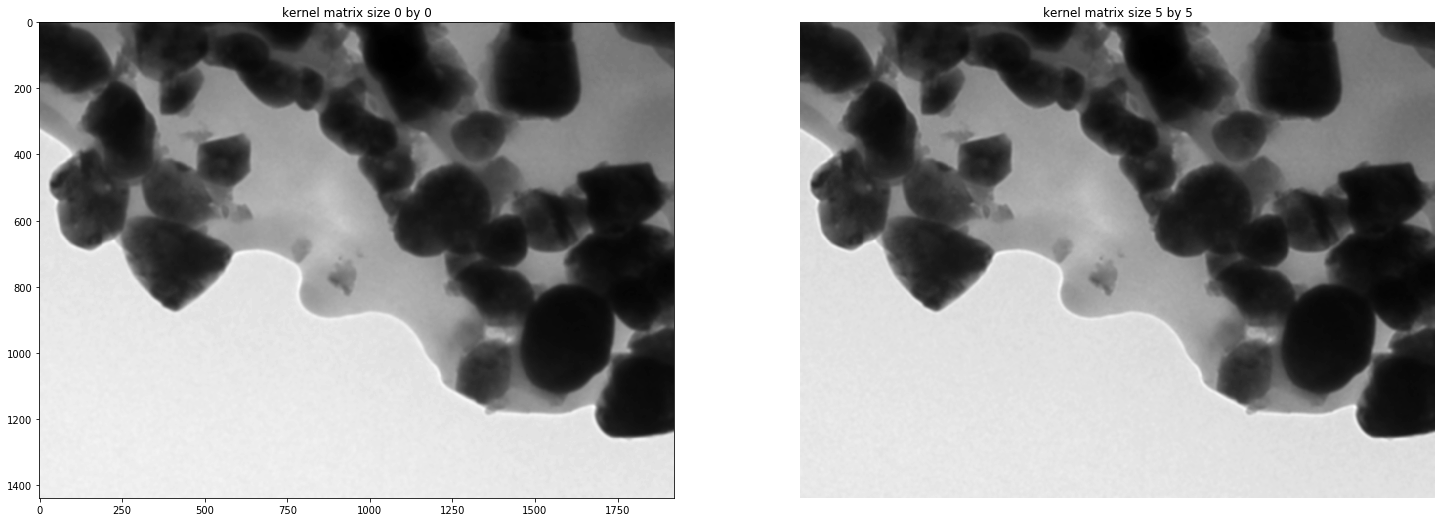

In [5]:
# apply gaussian blur
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
blur_1 = cv.GaussianBlur(gray_image, (0,0) ,cv.BORDER_DEFAULT) 
ax0.imshow(blur_1, cmap = plt.cm.gray) 
ax0.set_title("kernel matrix size 0 by 0")
blur_2 = cv.GaussianBlur(gray_image, (15,15) ,cv.BORDER_DEFAULT) # why only (0,0), (1,1), (5,5) work?
ax1.imshow(blur_2, cmap = plt.cm.gray)
ax1.set_title("kernel matrix size 5 by 5")

## Binary Threshold 

Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.

TODO: explain OTSU's method

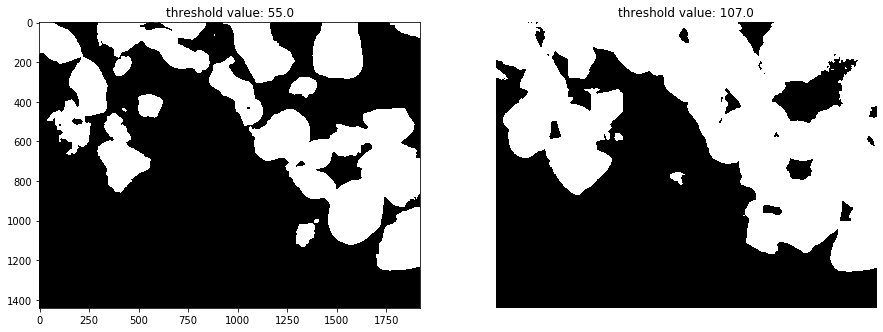

In [6]:
# auto binary threshold color image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")
ret_1, thresh_1 = cv.threshold(blur_1, 55, 255, cv.THRESH_BINARY_INV)
ax0.imshow(thresh_1, cmap = plt.cm.gray)
ax0.set_title("threshold value: " + str(ret_1));

# auto binary threshold grayscale image with Otsu's method
ret_2, thresh_2 = cv.threshold(blur_1, 120, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
ax1.imshow(thresh_2, cmap = plt.cm.gray)
ax1.set_title("threshold value: " + str(ret_2));

## Obtaining sure background and sure foreground

Text(0.5, 1.0, 'dist transform')

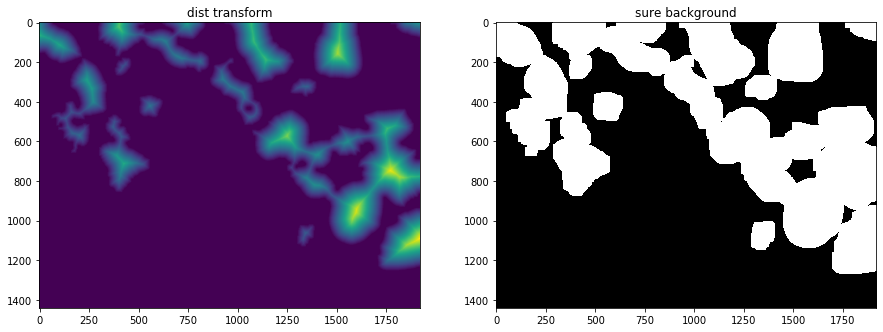

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh_1,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
ax1.imshow(sure_bg, cmap = plt.cm.gray)
ax1.set_title("sure background")

# Finding distance transform
# Lighter spots mean further away from contours
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)

ax0.imshow(dist_transform)
# ax0.imshow(unknown, cmap = plt.cm.gray)
ax0.set_title("dist transform")

## Threshold distance transform by the average value of intesities (TOOD: unsure of where to use)

Get average value of intensities

In [8]:
# get sum of inensity values in distance transform
dist_sum = np.sum(dist_transform)
# get count of nonzero intensities in distance transform
nonzero_counter = Counter()
for row in dist_transform:
    nonzero_counter += Counter(row)
nonzero_count = len(dist_transform)*len(dist_transform[0]) - nonzero_counter[0.0]

print(dist_sum, nonzero_count)
average_value = dist_sum / nonzero_count

# dist_norm = np.zeros((len(dist_transform), len(dist_transform[0])))

# for row in range(len(dist_transform)):
#     for col in range(len(dist_transform[0])):
#         if dist_transform[row][col] <= average_half and dist_transform[row][col] >= 2:
#             dist_norm[row][col] += average_half
#         else:
#             dist_norm[row][col] -= average_value
            
# ax1.imshow(dist_norm, cmap=plt.cm.gray)
# ax1.set_title("normalized distance transform")

31324508.0 817459


Threshold distance transform at average value

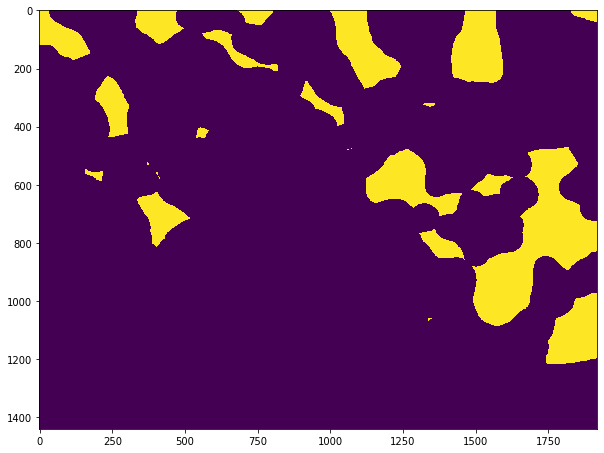

In [9]:
fig, ax0 = plt.subplots(1, 1, figsize=(10,10))
ret, dist_average = cv.threshold(dist_transform, average_value, 255, 0)
ax0.imshow(dist_average)

## 1. Contour Agglomerates

Text(0.5, 1.0, 'sure foreground')

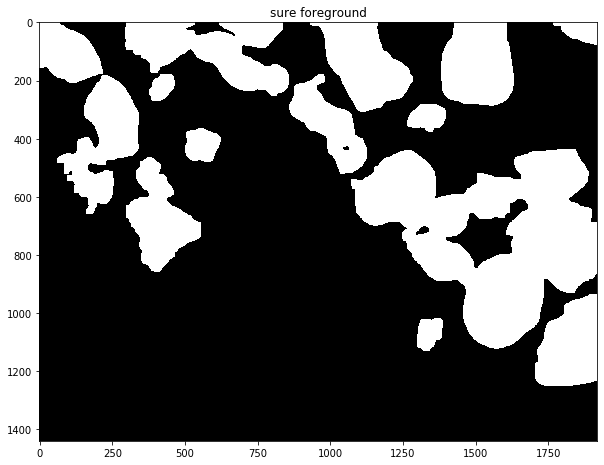

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

Text(0.5, 1.0, 'unknown = background - foreground')

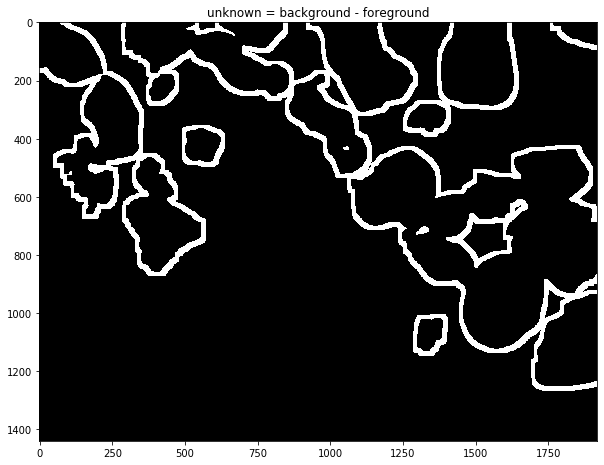

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

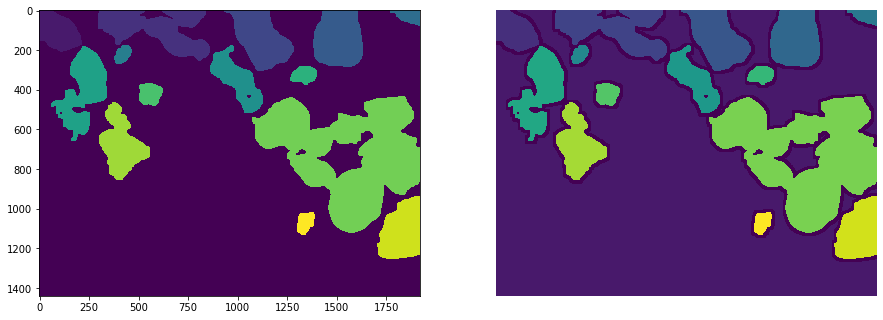

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [13]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

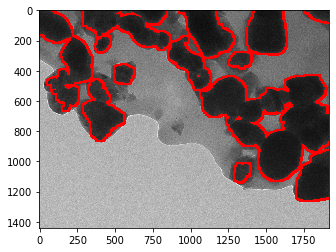

In [14]:
plt.imshow(color_copy_1)

## 2. Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

Text(0.5, 1.0, 'sure foreground')

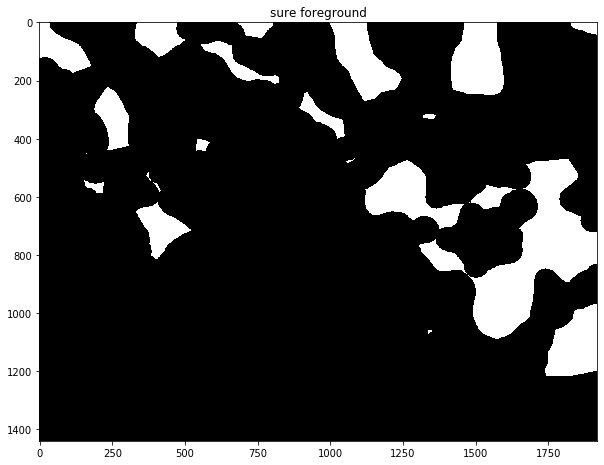

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.25*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [16]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

Text(0.5, 1.0, 'markers_2')

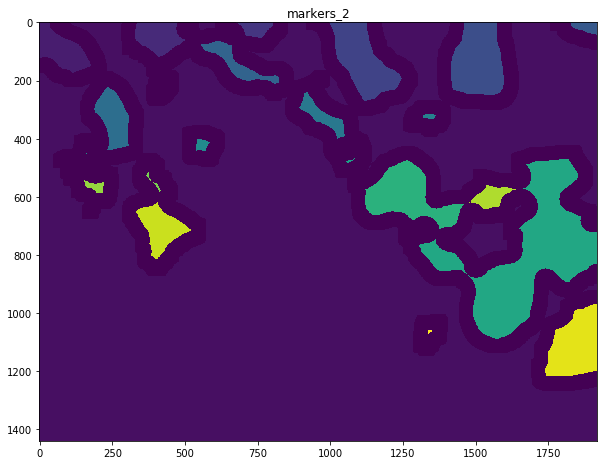

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, markers_2 = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
markers_2 = markers_2+1
# Now, mark the region of unknown with zero
markers_2[unknown_2==255] = 0

axs.imshow(markers_2)
axs.set_title("markers_2")

Run watershed algorithm from particle centers

16
15


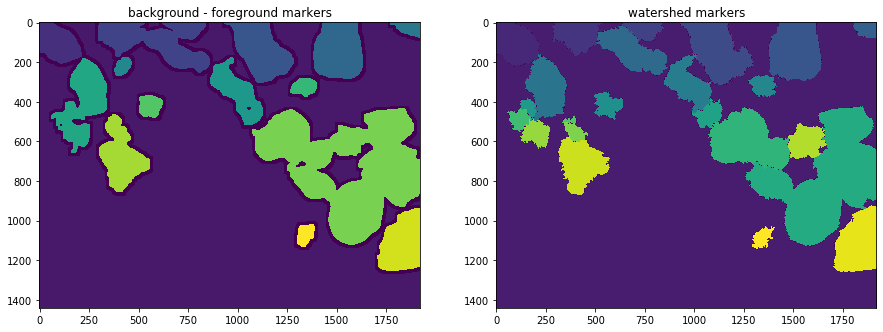

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

# copy input image
color_copy_2 = color_image.copy()

watershed_markers = cv.watershed(color_copy_2, markers_2)
color_copy_2[markers_2 == -1] = [255,0,0]

# apply Gaussian blur to markers to smooth out
# blur_watershed_markers = cv.blur(watershed_markers, (0,0) ,cv.BORDER_DEFAULT) 

ax0.imshow(markers)
ax0.set_title("background - foreground markers")
ax1.imshow(watershed_markers)
ax1.set_title("watershed markers")
# ax2.imshow(blur_watershed_markers)
# ax2.set_title("blurred watershed markers")

print(watershed_markers[600][1300])
print(watershed_markers[800][1750])

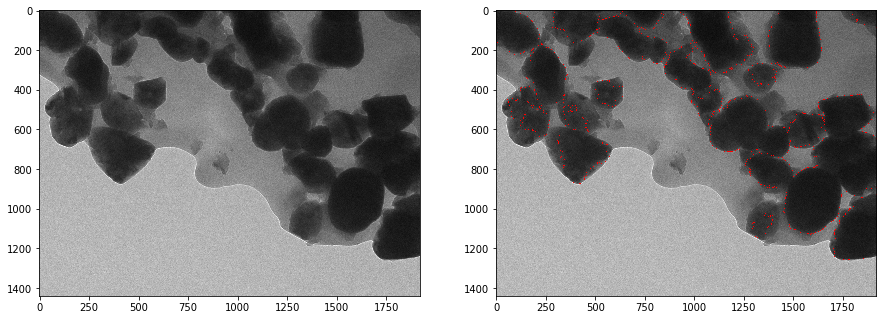

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(color_copy_2)

## 3. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

First create contour pixels and get their colors

In [20]:
# pixels are appended as (col, row) in order to feed to cv.lines() later on

# copy input image
color_copy_3 = color_image.copy()

# dictionary mapping colors to their pixels
contour_colors = {}

contour_size = 0
# loop through pixels in watershed markers
for row in range(1, len(watershed_markers) - 1):
    for col in range(1, len(watershed_markers[0]) - 1):
        # if pixel not in background
        if watershed_markers[row][col] != 1:
            # get current pixel and its neighbours 
            current = watershed_markers[row][col]
            up = watershed_markers[row-1][col]
            down = watershed_markers[row+1][col]
            left = watershed_markers[row][col-1]
            right = watershed_markers[row][col+1]
            # if not surrounded by uniform pixels
            if ((up != current) or (down != current) or (left != current) or (right != current)):
                # if the right pixel is different
                if (right != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the right pixel is not in background, add it to the dictionary
                    if (right != 1):
                        if right not in contour_colors:
                            contour_colors[right] = [(col+1, row)]
                        else:
                            contour_colors[right] += [(col+1,row)]
                        color_copy_3[row][col+1] = [255, 0, 0]
                        contour_size += 1
                        
                    color_copy_3[row][col] = [255, 0, 0]
                    contour_size += 1
                    
                # if the down pixel is different
                elif (down != current):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                    
                    # if the down pixel is not in background, add it to the dictionary
                    if (down != 1):
                        if down not in contour_colors:
                            contour_colors[down] = [(col, row+1)]
                        else:
                            contour_colors[down] += [(col,row+1)]
                        color_copy_3[row+1][col] = [255, 0, 0]
                        contour_size += 1
                        
                    color_copy_3[row][col] = [255, 0, 0]
                    contour_size += 1
                
                # if the up or left pixel is different than the current pixel and is not a border pixel
                elif (((up != 255) and (up != current)) or ((left != 255) and (left != current))):
                    # add current pixel to dictionary
                    if current not in contour_colors:
                        contour_colors[current] = [(col, row)]
                    else:
                        contour_colors[current] += [(col,row)]
                        
                    color_copy_3[row][col] = [255, 0, 0]                    
                    contour_size += 1

print(contour_size)

60246


Then use list of pixels grouped by color to get chord lengths

In [21]:
# remove -1 key from contour_colors because it represents bad contours drawn by cv.watershed()
del contour_colors[-1]

def pixel_distance(pixel1, pixel2):
    return np.power(np.power(pixel1[0] - pixel2[0], 2) + np.power(pixel1[1] - pixel2[1], 2), 0.5)
        
# loop through pixels colored with 2
# for pixel in contour_colors[2]:
#     distances

# test = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

test = contour_colors[10]

best_pairs = []
# loop through all colors
for color in contour_colors:
    # loop through all pixels in a color
    color_pixels = contour_colors[color]
    for i in range(len(color_pixels)):
        max = 0
        for j in range(len(color_pixels[i:])):
            distance = pixel_distance(color_pixels[i], color_pixels[j])
            if distance > max:
                max = distance
                best_pair = [color_pixels[i], color_pixels[j]]
    # keep track of longest chord length pair for each color 
    best_pairs += [best_pair]
            
print(best_pairs)

[[(94, 223), (1, 1)], [(396, 171), (296, 1)], [(782, 97), (635, 1)], [(1133, 319), (930, 1)], [(1559, 297), (1428, 1)], [(1918, 88), (1793, 1)], [(806, 269), (629, 16)], [(206, 502), (226, 160)], [(1001, 457), (993, 162)], [(1322, 382), (1319, 269)], [(597, 491), (541, 354)], [(1039, 535), (1079, 381)], [(181, 500), (157, 384)], [(1583, 1130), (1832, 425)], [(1414, 747), (1250, 430)], [(122, 556), (125, 430)], [(366, 512), (390, 473)], [(216, 638), (217, 486)], [(395, 603), (351, 503)], [(378, 512), (378, 510)], [(1522, 691), (1531, 510)], [(426, 872), (369, 574)], [(1778, 1257), (1890, 923)], [(1320, 1144), (1358, 1025)]]


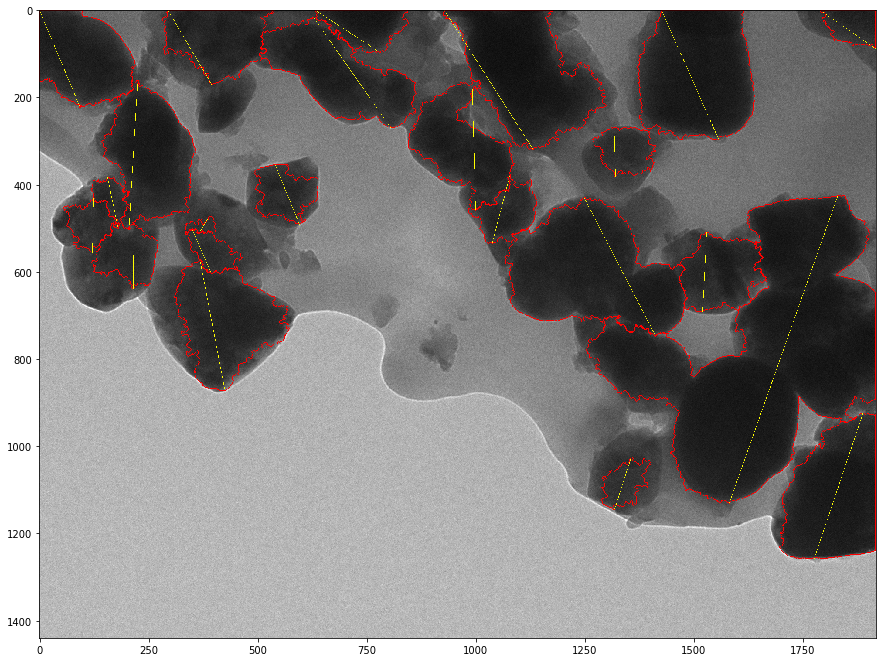

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))

# copy input image
# color_copy_4 = color_image.copy()

for best_pair in best_pairs:
    cv.line(color_copy_3, best_pair[0], best_pair[1], [255,255,0])

axs.imshow(color_copy_3)

plt.savefig("lines.png", dpi=500)

Visualizing contour for single color (14)

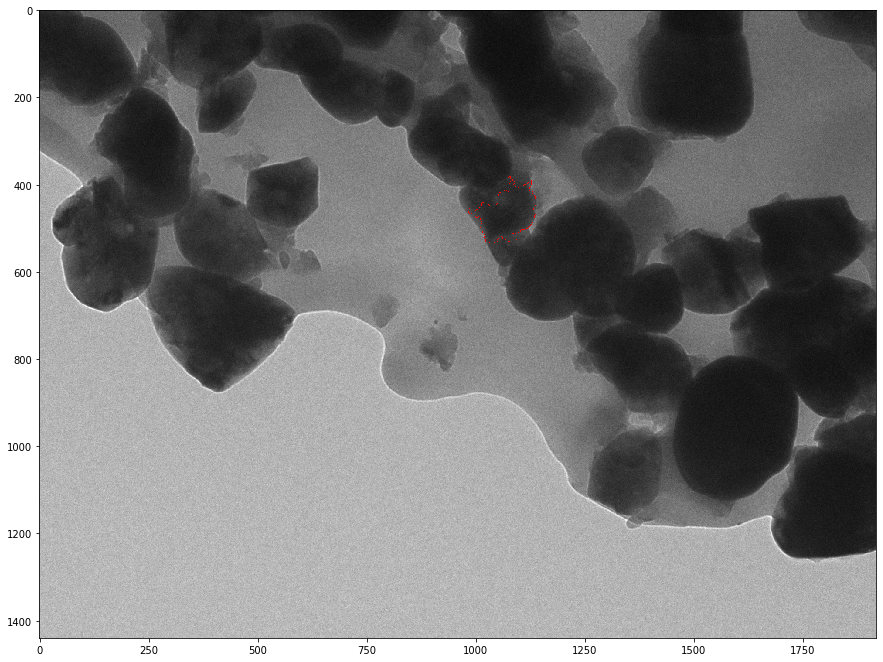

In [23]:
# fig, axs = plt.subplots(1, 1, figsize=(15,15))
# # copy input image
# individual_markers_outline = color_image.copy()
# current_color = 14
# current_pixels = contour_colors[current_color]
# for row in range(len(individual_markers_outline)):
#     for col in range(len(individual_markers_outline[0])):
#         if (col, row) in current_pixels:
#             individual_markers_outline[row][col] = [255,0,0]
# axs.imshow(individual_markers_outline)

# Save output as .txt for COMSOL

In [34]:
filename = "COMSOL_input.txt"

output = [("a", 1000, 78), ("b", 1000, 169), ("c", 1000, 103), ("x", 1000, 70), ("y", 1000, 500), ("z", 1000, 75)]

# save output as e.g. a3000 100[nm] where a/b/c is chord length direction, 3000 is particle number, 100[nm] is 

output_file = open(filename, "w")
for particle in output:
    output_file.writelines(particle[0] + str(particle[1]) + " " + str(particle[2]) + "[nm]" + "\n")
output_file.close()